In [2]:
from netCDF4 import Dataset
import numpy as np
#from numba import jit
from scipy.special import gamma as gam

def readScatProf(fname):
    fh=Dataset(fname,'r')
    temp=fh['temperature'][:]
    mass=fh['mass'][:]
    fraction=fh['fraction'][:]
    bscat=fh['bscat'][:]*4*np.pi
    Deq=10*(mass*1e3*6/np.pi)**(0.333) # in mm
    ext=fh['ext'][:]
    scat=fh['scat'][:]
    g=fh['g'][:]
    vfall=fh['fall_speed'][:]
    return temp,mass,fraction,bscat,Deq,ext,scat,g,vfall

def readScatProfR(fname):
    fh=Dataset(fname,'r')
    temp=fh['temperature'][:]
    mass=fh['mass'][:]
    bscat=fh['bscat'][:]*4*np.pi
    Deq=10*(mass*1e3*6/np.pi)**(0.333) # in mm
    ext=fh['ext'][:]
    vfall=fh['fall_speed'][:]
    scat=fh['scat'][:]
    g=fh['g'][:]
    #print(fh)
    #stop
    return temp,mass,bscat,Deq,ext,scat,g,vfall,fh

In [3]:
import glob
fss=sorted(glob.glob("/Users/mgrecu/scatteringProp/ice*nc"))
fsr=sorted(glob.glob("/Users/mgrecu/scatteringProp/water*nc"))

for f1,f2 in zip(fss,fsr):
    #print(f1,f2)
    freq1=f1.split("_")[1].split("-GHz")[0]
    freq2=f2.split("_")[1].split("-GHz")[0]
    print(freq1,freq2)
    tempI,massI,fractionI,bscatI,DeqI,extI,scatI,gI,vfallI=readScatProf(f1)
    tempR,massR,bscatR,DeqR,extR,scatR,gR,vfallR,fh=readScatProfR(f2)
    break

13.8 13.8


In [14]:
#print(tempR.shape)
#print(bscatI.shape)
#print(tempI.shape)
#print(bscatR.shape)

(5,)
(5, 25, 200)
(5,)
(5, 200)


In [83]:
def get_Zn(w,nw,lambd,W,Z,att,dm,dm_out,rrate_out,\
           kext,kscat,g,Deq,bscat,ext,scat,asym,vfall,mu,wl,fract):
    dD=0.05
    rhow=1 #gcm-3
    Dint=np.arange(260)*dD+dD/2.0
    bscatInt=np.exp(np.interp(Dint,Deq,np.log(bscat)))  #m^2
    extInt=np.exp(np.interp(Dint,Deq,np.log(ext)))  #m^2
    vfallInt=np.interp(Dint,Deq,vfall)
    scatInt=np.exp(np.interp(Dint,Deq,np.log(scat)))  #m^2
    gInt=np.interp(Dint,Deq,(asym))  #m^2
    fact=1e3/np.pi**5/0.93*wl**4
    nP=W.shape[0]
    f_mu=6/4**4*(4+mu)**(mu+4)/gam(mu+4)
    #print(vfallInt)
    for j in range(nP):
        vdop=0
        nc0=0
        Vol=0
        #zray=0.0
        rrate=0.0
        for i in range(260):
            d=dD*i+dD/2
            Nd=f_mu*np.exp(-lambd[j]*d)*(d/dm[j])**mu*dD #(mm)
            W[j]=W[j]+nw[j]*Nd*(0.1*d)**3*np.pi/6*rhow*fract*1e-3 #(g/m3)
            dm_out[j]=dm_out[j]+nw[j]*Nd*(0.1*d)**3*np.pi/6*rhow*fract*(d)*1e-3 #(g/m3)
            Z[j]=Z[j]+nw[j]*Nd*bscatInt[i]
            vdop=vdop+nw[j]*Nd*bscatInt[i]*vfallInt[i]
            rrate=rrate+nw[j]*Nd*(0.1*d)**3*np.pi/6*vfallInt[i]
            att[j]=att[j]+nw[j]*Nd*extInt[i]*4.343 #(/km)
            kext[j]=kext[j]+nw[j]*Nd*extInt[i] #(/km)
            kscat[j]=kscat[j]+nw[j]*Nd*scatInt[i] #(/km)
            g[j]=g[j]+nw[j]*Nd*scatInt[i]*gInt[i] #(/km)
            nc0=nc0+nw[j]*Nd
            Vol=Vol+nw[j]*Nd*(1e-3*d)**3*np.pi/6
        Z[j]=np.log10(Z[j]*fact)*10
        dm_out[j]=dm_out[j]/(W[j]+1e-9)
        rrate_out[j]=rrate*3.6e-3

def calcZkuR(rwc,Deq_r,bscat_r,ext_r,scat_r,g_r,vfall_r,mu,wl,fract):
    Nw=rwc.copy()*0+0.08e8
    dm=(4**4*rwc/(np.pi*fract*1e6*Nw))**0.25*1e3 # in mm
    nwr=rwc.copy()*0.0+Nw
    w_r=rwc.copy()*0.0
    prate_r=rwc.copy()*0.0
    z_r=rwc.copy()*0.0
    att_r=rwc.copy()*0.0
    dm_r=rwc.copy()*0.0
    kext_out_r=rwc.copy()*0.0
    kscat_out_r=rwc.copy()*0.0
    g_out_r=rwc.copy()*0.0
    lambd=(4+mu)/dm
    get_Zn(rwc,nwr,lambd,w_r,z_r,att_r,dm,dm_r,\
           prate_r,kext_out_r,kscat_out_r,g_out_r,Deq_r,bscat_r[4,:],ext_r[4,:],\
           scat_r[4,:],g_r[4,:],\
           vfall_r,mu,wl,fract)
    #print(rwc.mean())
    #print(w_r.mean())
    return nwr,z_r,att_r,prate_r,kext_out_r,kscat_out_r,g_out_r,dm_r,w_r

def calcZkuS(rwc,Deq_r,bscat_r,ext_r,scat_r,g_r,vfall_r,mu,wl,itemp,ifract,fract):
    Nw=rwc.copy()*0+0.08e8
    dm=(4**4*rwc/(np.pi*fract*1e6*Nw))**0.25*1e3 # in mm
    nwr=rwc.copy()*0.0+Nw
    w_r=rwc.copy()*0.0
    prate_r=rwc.copy()*0.0
    z_r=rwc.copy()*0.0
    att_r=rwc.copy()*0.0
    dm_r=rwc.copy()*0.0
    kext_out_r=rwc.copy()*0.0
    kscat_out_r=rwc.copy()*0.0
    g_out_r=rwc.copy()*0.0
    lambd=(4+mu)/dm
    get_Zn(rwc,nwr,lambd,w_r,z_r,att_r,dm,dm_r,\
           prate_r,kext_out_r,kscat_out_r,g_out_r,Deq_r[ifract,:],bscat_r[itemp,ifract,:],ext_r[itemp,ifract,:],\
           scat_r[itemp,ifract,:],g_r[itemp,ifract,:],\
           vfall_r[ifract,:],mu,wl,fract)
    #get_Zn(rwc,nwr,lambd,w_s,z_s,att_s,dm,dm_s,\
    #       prate_s,Deq[14,:],bscat[3,14,:],ext[3,14,:],vfall[3,:],mu,wl)
    #print(rwc.mean())
    #print(w_r.mean())
    return nwr,z_r,att_r,prate_r,kext_out_r,kscat_out_r,g_out_r,dm_r,w_r

In [84]:
rwc=(np.logspace(-3,1.5,300))
#print(rwc)
mu=2.0
freqL=[]
dmR=[]
dmI=[]
kScatR=[]
kScatI=[]
kExtR=[]
kExtI=[]
gRL=[]
gIL=[]
zR=[]
zI=[]
swcL=[]
rwcL=[]
for f1,f2 in zip(fss,fsr):
    #print(f1,f2)
    freq1=f1.split("_")[1].split("-GHz")[0]
    freq2=f2.split("_")[1].split("-GHz")[0]
    print(freq1,freq2)
    tempI,massI,fractionI,bscatI,DeqI,extI,scatI,gI,vfallI=readScatProf(f1)
    tempR,massR,bscatR,DeqR,extR,scatR,gR,vfallR,fh=readScatProfR(f2)
    freqL.append(float(freq1))
    wl=300/float(freq1)
    fract=1.0
    nwr,z_r,att_r,prate_r,kext_out_r,kscat_out_r,g_out_r,dm_r,w_r=calcZkuR(rwc,DeqR,bscatR,extR,scatR,gR,vfallR,mu,wl,fract)
    dmR.append(dm_r)
    kScatR.append(kscat_out_r)
    kExtR.append(kext_out_r)
    gRL.append(g_out_r)
    zR.append(z_r)
    rwcL.append(w_r)
    itemp,ifraction=3,5
    fract=1.0
    nws,z_s,att_s,prate_s,kext_out_s,kscat_out_s,g_out_s,dm_s,w_s=calcZkuS(rwc,DeqI,bscatI,extI,scatI,gI,vfallI,mu,wl,itemp,ifraction,fract)
    dmI.append(dm_s)
    kScatI.append(kscat_out_s)
    kExtI.append(kext_out_s)
    gIL.append(g_out_s)
    zI.append(z_s)
    swcL.append(w_s)


13.8 13.8
183.31 183.31
325.15 325.15
35 35
94 94


In [88]:
import xarray as xr

ds=xr.Dataset({'dmR':(['freq','pwc'],np.array(dmR)),'dmI':(['freq','pwc'],np.array(dmI)),\
                'kScatR':(['freq','pwc'],np.array(kScatR)),'kScatI':(['freq','pwc'],np.array(kScatI)),\
                'kExtR':(['freq','pwc'],np.array(kExtR)),'kExtI':(['freq','pwc'],np.array(kExtI)),\
                'gR':(['freq','pwc'],np.array(gRL)),'gI':(['freq','pwc'],np.array(gIL)),\
                'zR':(['freq','pwc'],np.array(zR)),'zI':(['freq','pwc'],np.array(zI)),\
                'swc':(['freq','pwc'],np.array(swcL)),'rwc':(['freq','pwc'],np.array(rwcL))},\
                coords={'freq':freqL,'pwc':rwc})

ds.to_netcdf('scatPropSSRG.nc',encoding={'dmR':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'dmI':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'kScatR':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'kScatI':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'kExtR':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'kExtI':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'gR':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'gI':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'zR':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'zI':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'swc':{'dtype':'float32','zlib':True,'complevel':5},\
                                        'rwc':{'dtype':'float32','zlib':True,'complevel':5}})


24.678910454824894 19.064448658753243


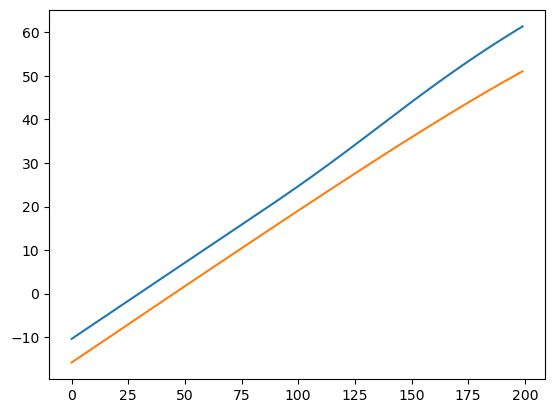

In [64]:
#plt.plot(rwc,w_s/rwc)
print(z_r[100],z_s[100])
#plt.plot(z_r)
plt.plot(z_s)


dict_keys(['kextG', 'kextS', 'kextH', 'kextR', 'salbG', 'salbS', 'salbH', 'salbR', 'asymG', 'asymS', 'asymH', 'asymR', 'dmr', 'dms', 'dmg', 'dmh', 'rwc', 'swc', 'gwc', 'hwc', 'rainRate', 'snowRate', 'graupRate', 'hailRate', 'zKuR', 'zKuS', 'zKuG', 'zKuH', 'zKaR', 'zKaS', 'zKaG', 'zKaH', 'attKuR', 'attKuS', 'attKuG', 'attKuH', 'attKaR', 'attKaS', 'attKaG'])


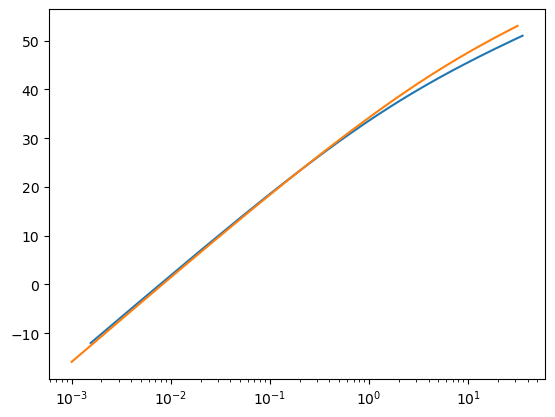

In [79]:
#print(z_r)
#print(DeqR)
#print(z_r[0:5],dm_r[0:5],rwc[0:5])
#print(z_r[-5:],dm_r[-5:],rwc[-5:])
import matplotlib.pyplot as plt
import netCDF4 as nc
with nc.Dataset("/Users/mgrecu/myPythonPackages/lookupTables/scatteringTablesGPM.nc") as f:
    print(f.variables.keys())
    rwcDPR=f["rwc"][:]
    zKuR=f["zKuR"][:]
    attKuR=f["attKuR"][:]
    swcDPR=f["swc"][:]
    zKuS=f["zKuS"][:]

#plt.semilogx(attKuR[100:273],zKuR[100:273])
#plt.semilogx(att_r[:],z_r[:])
plt.semilogx(swcDPR[:253],zKuS[:253])
plt.semilogx(w_s,z_s)
#plt.semilogx(w_r[:],z_r[:273])
#plt.ylim(40,50)
#plt.xlim(1,3)
#plt.grid()